In [1]:
import pandas as pd
import glob
import os
import re

# Folder where your files are
folder = "../data/processed"

# Pattern to match 'hmm_<asset>' at the start of the filename
pattern = re.compile(r'hmm_([A-Za-z0-9]+)')

# Find all CSV files starting with "hmm_"
files = glob.glob(os.path.join(folder, "hmm_*.csv"))

returns = []

for file in files:
    filename = os.path.basename(file)
    match = pattern.match(filename)
    if match:
        asset = match.group(1)
        df = pd.read_csv(
            file,
            index_col=0,       # use first column as index
            parse_dates=True   # parse index as datetime if possible
        )
        
        returns.append(df[f"{asset}_ret"])

In [2]:
portfolio_returns = (
    pd.concat(returns, axis=1)
      .mean(axis=1)
      .rename("raw_returns")
)

In [3]:
rolling_vol = portfolio_returns.rolling(20).std().rename("portfolio_vol")

In [4]:
portfolio_features = pd.concat(
    [portfolio_returns, rolling_vol],
    axis=1
).dropna()

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(portfolio_features)

X = pd.DataFrame(
    X_scaled,
    index=portfolio_features.index,
    columns=portfolio_features.columns
)


In [6]:
portfolio_features.head()

,raw_returns,portfolio_vol
Date,,
2015-03-02,0.001854,0.005400
2015-03-03,-0.004826,0.005105
2015-03-04,-0.001349,0.004758
2015-03-05,-0.000251,0.004763
2015-03-06,-0.015442,0.005862


In [7]:
portfolio_features.describe()

,raw_returns,portfolio_vol
count,2723.000000,2723.000000
mean,0.000563,0.008308
std,0.009882,0.005399
min,-0.110486,0.002390
25%,-0.003530,0.005152
50%,0.000952,0.006721
75%,0.005452,0.010145
max,0.076479,0.052392


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

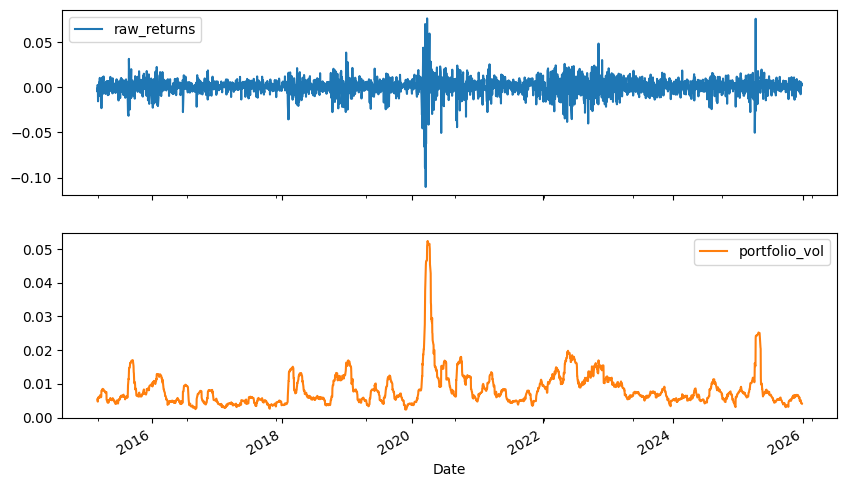

In [8]:
portfolio_features.plot(subplots=True, figsize=(10,6))

In [9]:
from hmmlearn.hmm import GaussianHMM
import numpy as np
import pandas as pd

In [10]:
hmm = GaussianHMM(
    n_components=2,
    covariance_type="full",
    n_iter=1000,
    random_state=42
)


In [11]:
hmm.fit(X)

,n_components,2
,covariance_type,'full'
,min_covar,0.001
,startprob_prior,1.0
,transmat_prior,1.0
,means_prior,0
,means_weight,0
,covars_prior,0.01
,covars_weight,1
,algorithm,'viterbi'
,random_state,42


In [12]:
regimes = hmm.predict(X)


In [13]:
regime_probs = hmm.predict_proba(X)

In [14]:
portfolio_hmm = portfolio_features.copy()

portfolio_hmm["regime"] = regimes
portfolio_hmm["prob_regime_0"] = regime_probs[:, 0]
portfolio_hmm["prob_regime_1"] = regime_probs[:, 1]

In [15]:
regime_stats = (
    portfolio_hmm
    .groupby("regime")
    .agg(
        mean_return=("raw_returns", "mean"),
        volatility=("raw_returns", "std"),
        observations=("raw_returns", "count")
    )
)

regime_stats


,mean_return,volatility,observations
regime,,,
0,0.000886,0.005835,1829
1,-0.000100,0.015078,894


<Axes: title={'center': 'Portfolio-Level Regimes'}, xlabel='Date'>

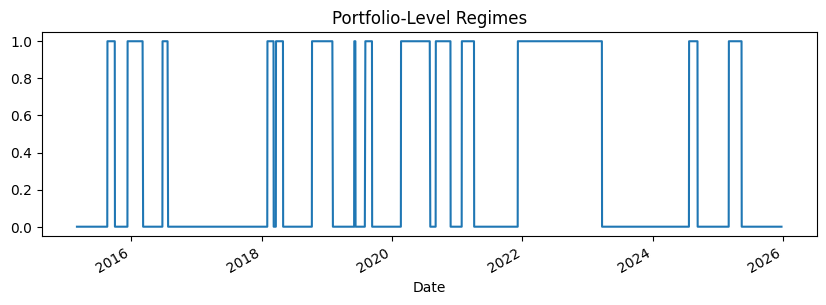

In [16]:
portfolio_hmm["regime"].plot(
    title="Portfolio-Level Regimes",
    figsize=(10, 3)
)

In [17]:
risk_off_regime = regime_stats["volatility"].idxmax()
risk_on_regime = regime_stats["volatility"].idxmin()

In [18]:
portfolio_hmm["risk_off_prob"] = (
    portfolio_hmm[f"prob_regime_{risk_off_regime}"]
)

In [19]:
def exposure_scaler(p, low=0.4, high=0.7, min_scale=0.3):
    if p < low:
        return 1.0
    elif p > high:
        return min_scale
    else:
        return 1.0 - (p - low) / (high - low) * (1.0 - min_scale)


In [20]:
portfolio_hmm["exposure"] = (
    portfolio_hmm["risk_off_prob"]
    .apply(exposure_scaler)
)

In [21]:
portfolio_hmm["exposure"].describe()

count    2723.000000
mean        0.771104
std         0.327408
min         0.300000
25%         0.300000
50%         1.000000
75%         1.000000
max         1.000000
Name: exposure, dtype: float64

In [22]:
portfolio_hmm["scaled_returns"] = (
    portfolio_hmm["raw_returns"]
    * portfolio_hmm["exposure"]
)

<Axes: title={'center': 'Portfolio: Raw vs Regime-Controlled Returns'}, xlabel='Date'>

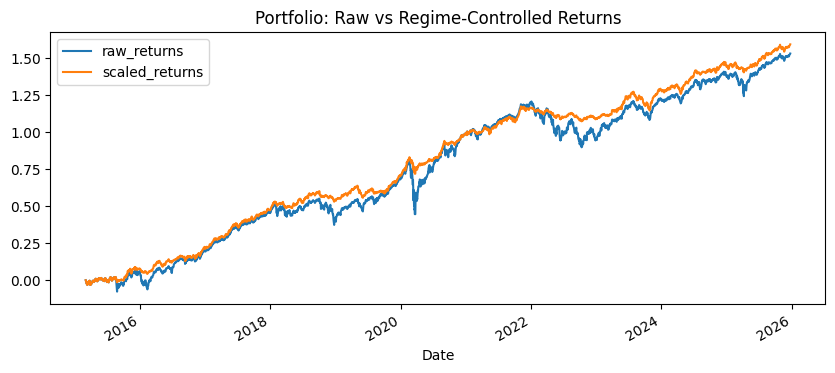

In [23]:
portfolio_hmm[["raw_returns", "scaled_returns"]].cumsum().plot(
    figsize=(10, 4),
    title="Portfolio: Raw vs Regime-Controlled Returns"
)

In [24]:
portfolio_hmm.to_csv("../data/processed/portfolio_hmm.csv")